<a href="https://colab.research.google.com/github/Anya232536/project_ml/blob/main/Mental_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, average_precision_score, f1_score, accuracy_score, recall_score, precision_score


import warnings
warnings.filterwarnings('ignore')


In [ ]:
# KAGGLE_ENV = os.path.exists('/kaggle/input')

# # Allowing loading both in Kaggle and in VS Code
# if KAGGLE_ENV:
#     # When running on Kaggle
#     file_path = "/kaggle/input/student-depression-dataset/Student Depression Dataset.csv"
# else:
#     # When running locally
#     file_path = "Student Depression Dataset.csv"  # Adjust to your local path

# # Now use file_path for reading the CSV
# df = pd.read_csv(file_path)
# initial_df = df.copy()
# # First look
# df.head()

In [ ]:
df = pd.read_csv('student_depression_dataset.csv')
df.drop(columns = ['Profession', 'Job Satisfaction', 'Work Pressure'], inplace=True)
#убираю эти строки, так как в основном студенты
df.head(5)

,id,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,5.0,8.97,2.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,2.0,5.90,5.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,3.0,7.03,5.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,3.0,5.59,2.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,4.0,8.13,3.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


Гипотезы:
- есть значительная корреляция с наличием суицидальных мыслей и депресией
- у людей с высокими средними баллами и низкой удовлетворенностью учебой с большей вроятностью будет депрессия (высокая корреляция)
- Образ жизни (количество сна, режим питания и учебы) и наличие дерессии сильно скорреклированные факторы
- Количество времени за учебой и средний балл сильно взаимосязаны
- Корреляция между городом и наличием депрессии будет низкой (фактор не будет значимым)
- Финановый стресс значительно сказывается на наличие депрессии. Вероятно финансовый стресс будет отрицательноскоррелирован также с успеваемость, суицидальными мыслями и удовлетвореностью учебой/работой.
- Финансовый стресс мужчин больше, чем женщин.




In [ ]:
df['Gender'].replace(['Male', 'Female'], [1, 0], inplace = True)
df['Family History of Mental Illness'].replace(['Yes', 'No'], [1, 0], inplace = True)
df['Have you ever had suicidal thoughts ?'].replace(['Yes', 'No'], [1, 0], inplace = True)
df['Financial Stress'].replace(['?'], [1.0], inplace = True) #пропущенные строки оценим максимально консервативно - самое низкое значение
df['Financial Stress'] = df['Financial Stress'].astype(float)

df.head(5)

,id,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,1,33.0,Visakhapatnam,5.0,8.97,2.0,'5-6 hours',Healthy,B.Pharm,1,3.0,1.0,0,1
1,8,0,24.0,Bangalore,2.0,5.90,5.0,'5-6 hours',Moderate,BSc,0,3.0,2.0,1,0
2,26,1,31.0,Srinagar,3.0,7.03,5.0,'Less than 5 hours',Healthy,BA,0,9.0,1.0,1,0
3,30,0,28.0,Varanasi,3.0,5.59,2.0,'7-8 hours',Moderate,BCA,1,4.0,5.0,1,1
4,32,0,25.0,Jaipur,4.0,8.13,3.0,'5-6 hours',Moderate,M.Tech,1,1.0,1.0,0,0


In [ ]:
dict_ = {}
for col in df.columns:
  dict_[col] = col.replace(' ', '_').replace('/', '_').replace('?', '')
dict_
df.rename(columns = dict_, inplace= True)
df.columns

Index(['id', 'Gender', 'Age', 'City', 'Academic_Pressure', 'CGPA',
       'Study_Satisfaction', 'Sleep_Duration', 'Dietary_Habits', 'Degree',
       'Have_you_ever_had_suicidal_thoughts_', 'Work_Study_Hours',
       'Financial_Stress', 'Family_History_of_Mental_Illness', 'Depression'],
      dtype='object')

In [ ]:
num_col = ['Gender', 'Age', 'Academic_Pressure', 'CGPA', 'Study_Satisfaction', 'Have_you_ever_had_suicidal_thoughts_', 'Work_Study_Hours', 'Financial_Stress', 'Family_History_of_Mental_Illness', 'Depression']

Academic/Work Pressure - числовой рейтинг, который количественно определяет уровень давления, которое студент испытывает из-за академических/рабочих обязанностей.

CGPA - совокупный средний балл успеваемости, который является количественным показателем академической успеваемости учащегося. Это может быть соотнесено с показателями психического здоровья для анализа влияния академических успехов или проблем.

Study Satisfaction/Job Satisfaction - показатель (часто числовой), показывающий, насколько студент удовлетворен своим академическим/рабочим опытом.



РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ

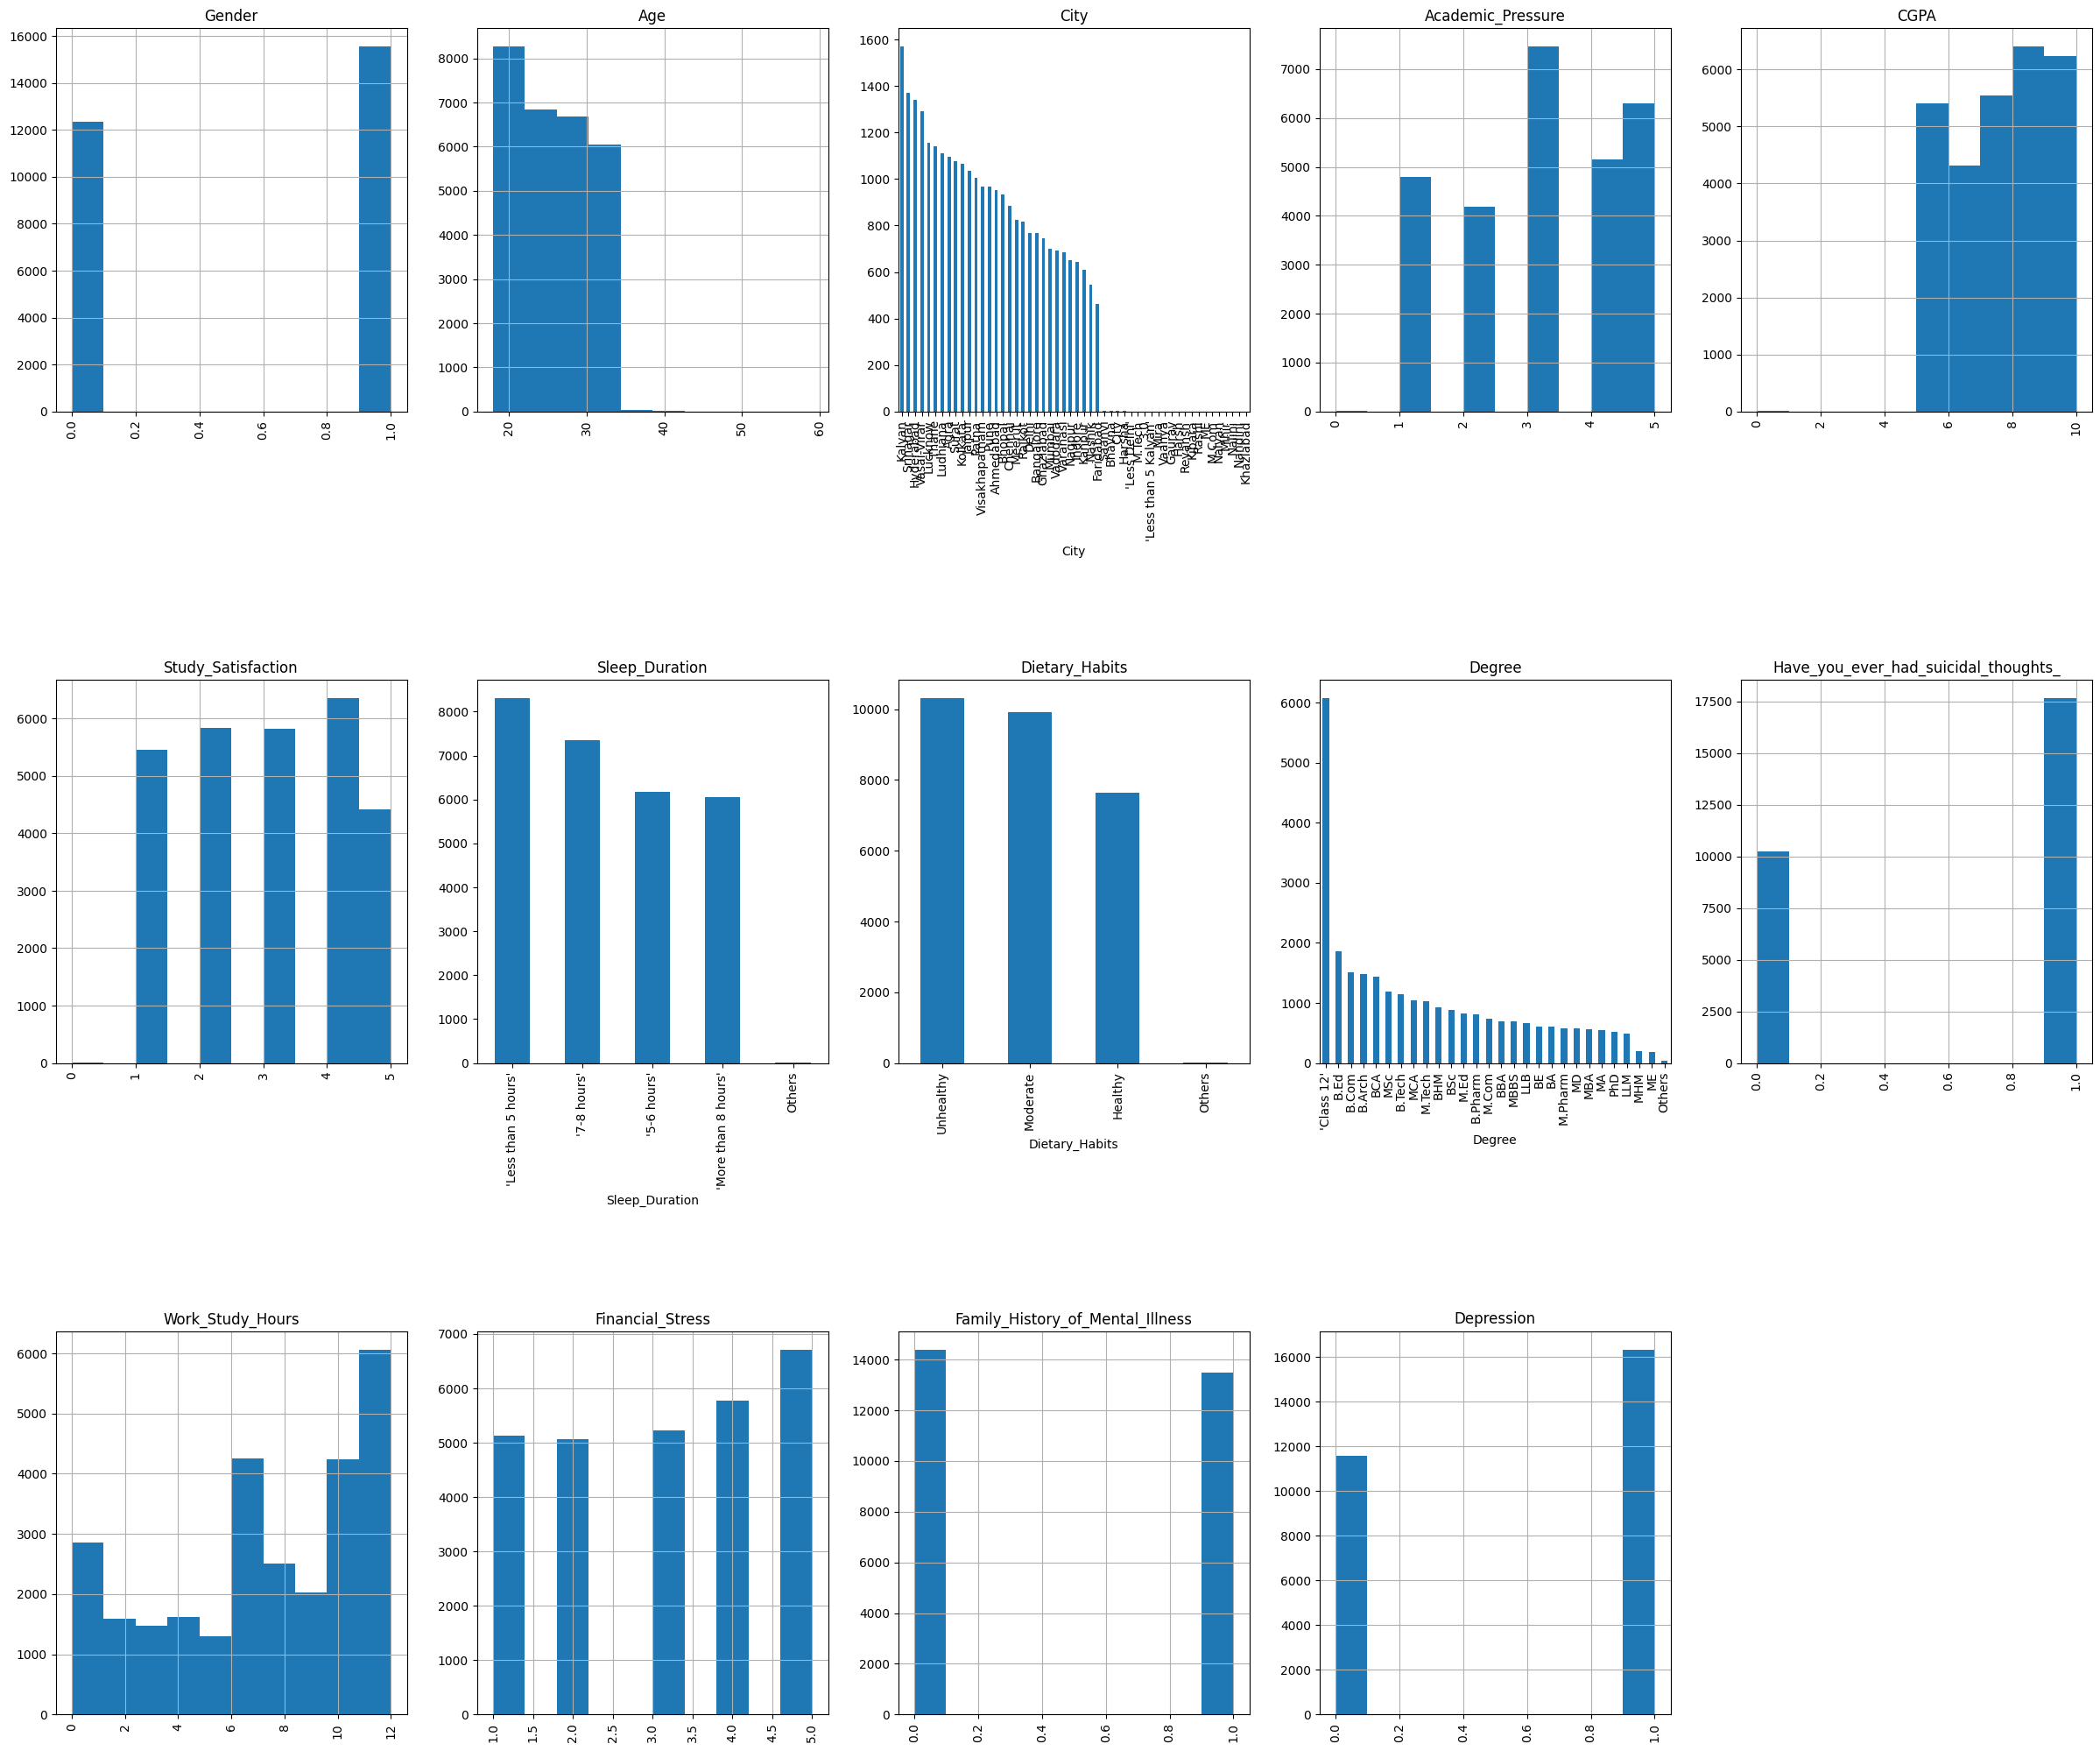

In [ ]:
fig = plt.figure(figsize = (30,25))
cols = 5
row = int(df.shape[1] / cols)

for i, column in enumerate(df.columns[1::]):
  ax = fig.add_subplot(row, cols, i + 1)
  ax.set_title(column)
  if df.dtypes[column] == object:
        df[column].value_counts().plot(kind="bar", axes=ax)
  else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

Посмотрим подробнее на числовые признаки

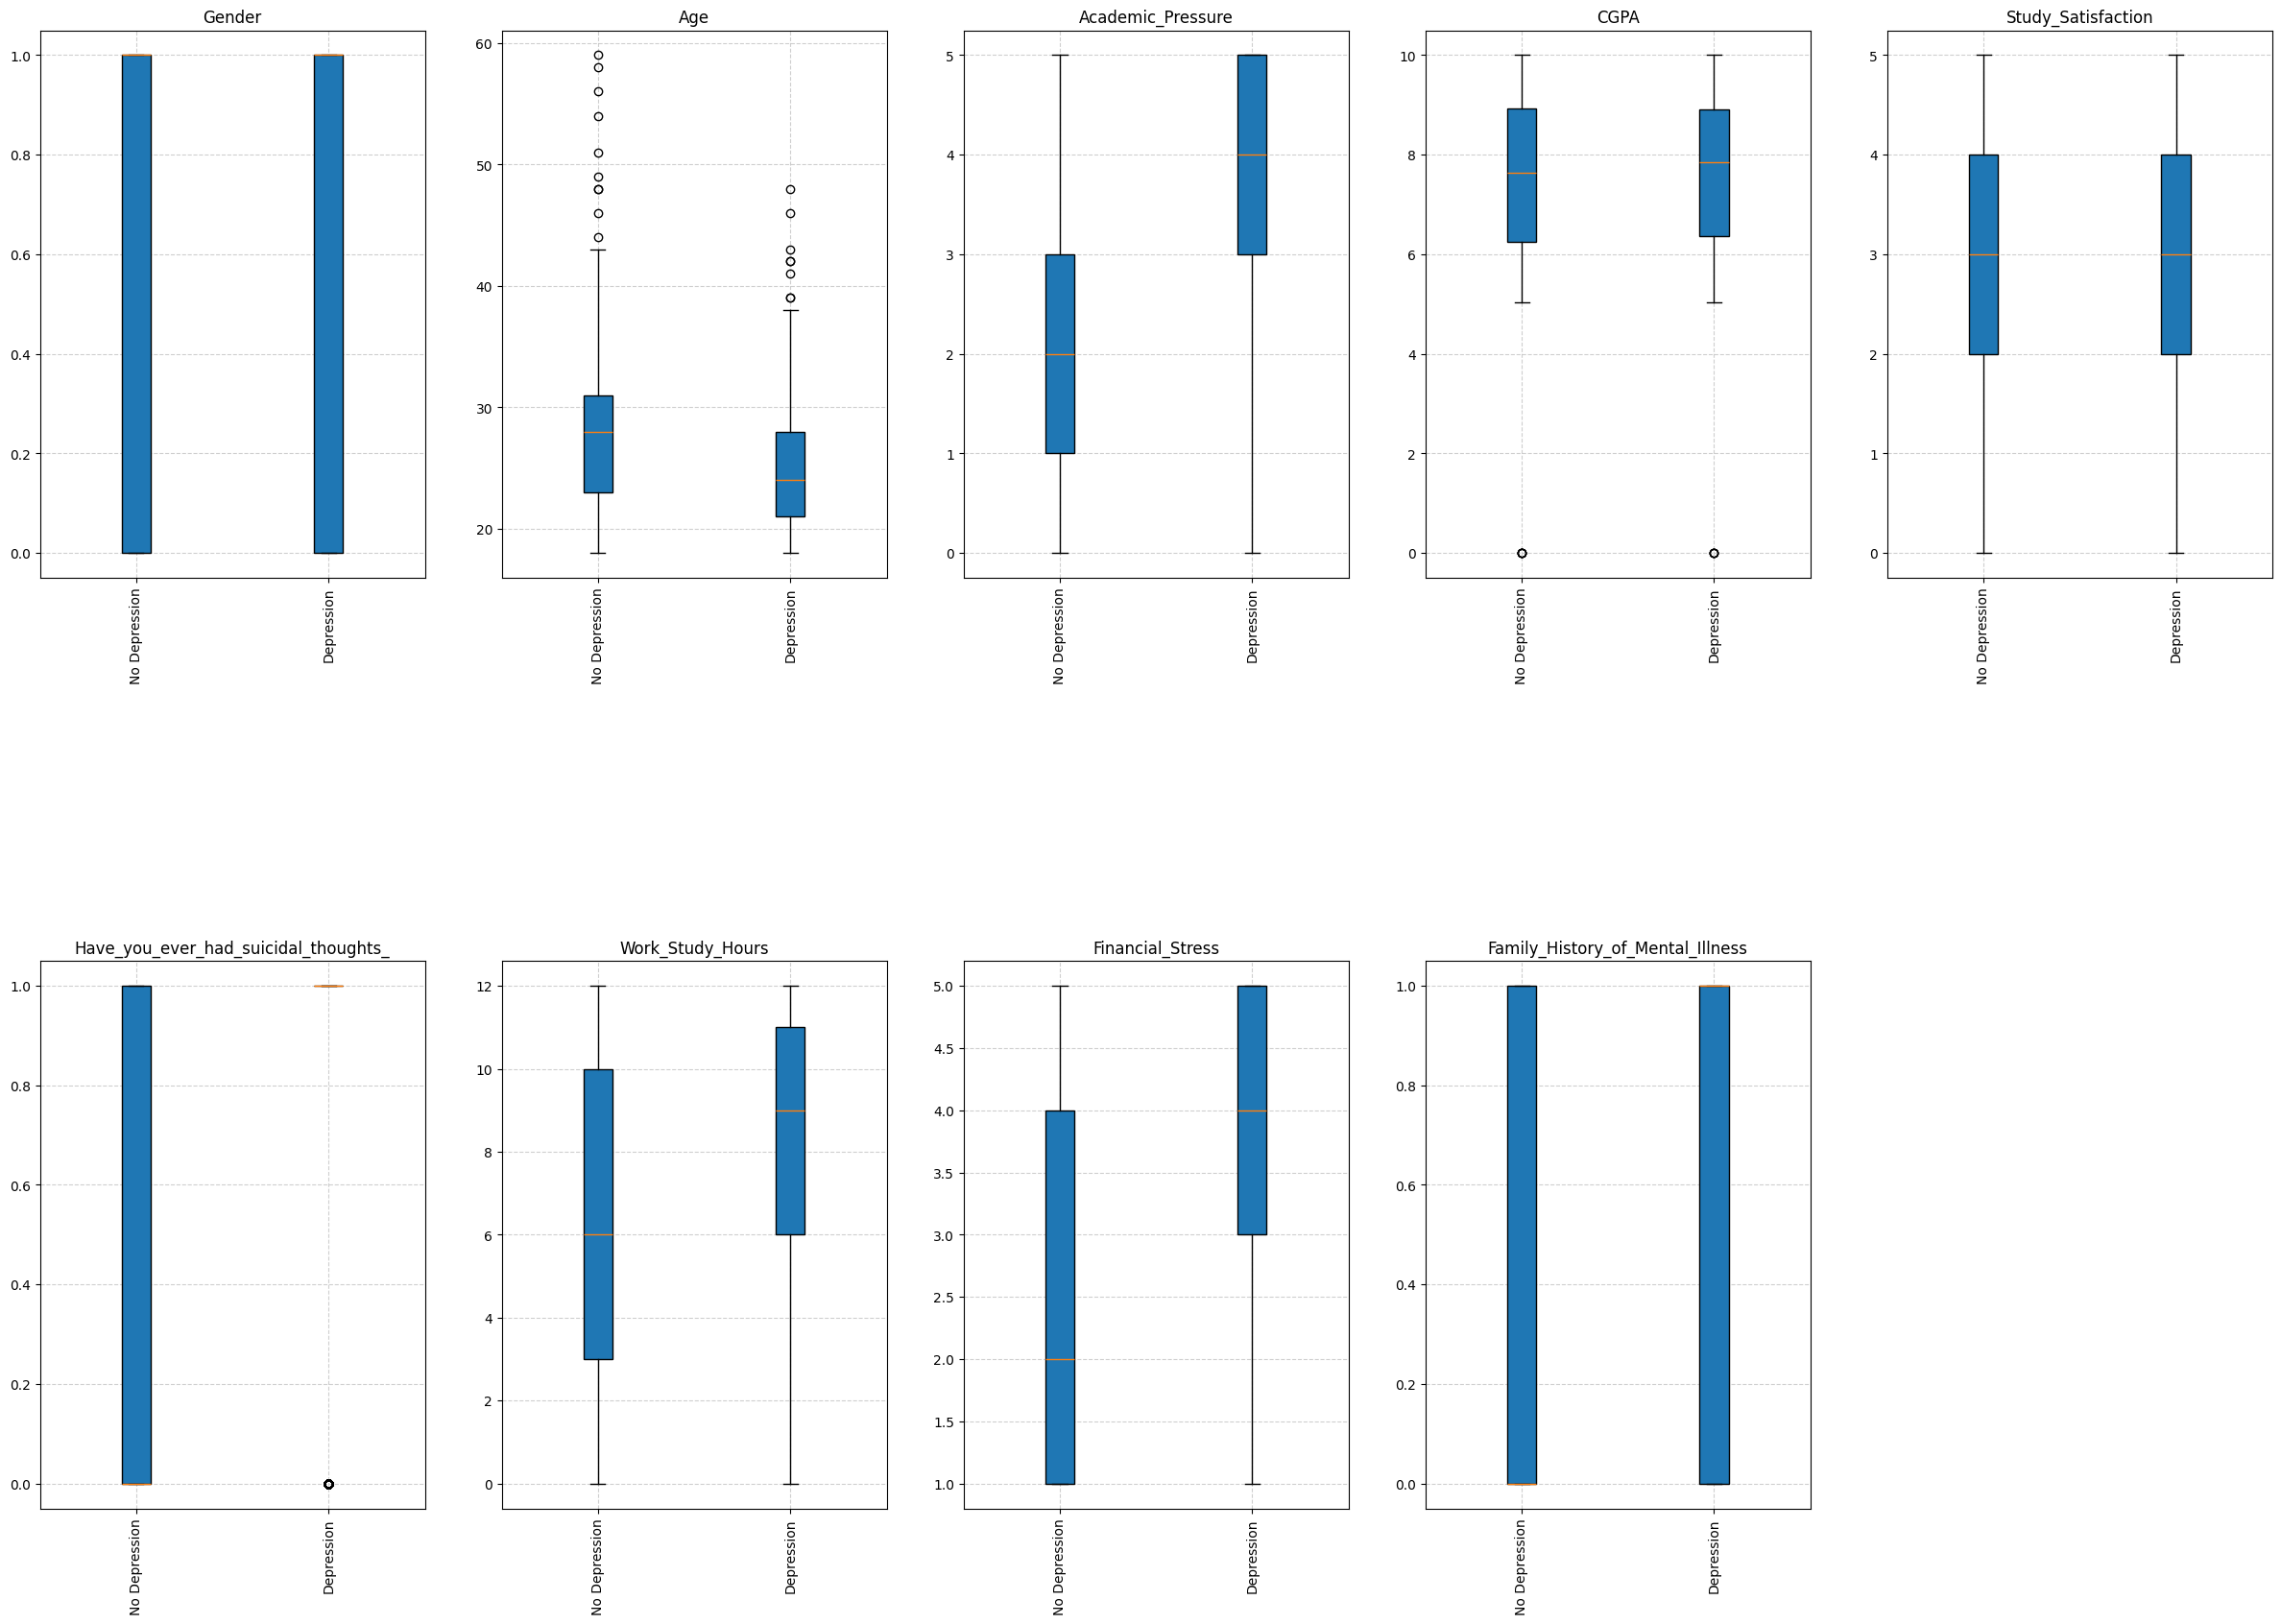

In [ ]:
fig = plt.figure(figsize = (30,20))
#col = ['Age', 'Academic_Pressure', 'CGPA', 'Study_Satisfaction']
cols = 5
rows = 2
df_not_depression = df[df['Depression']==0]
df_depression = df[df['Depression']==1]

for i, column in enumerate(num_col[0:len(num_col)-1]):
  ax = fig.add_subplot(rows, cols, i + 1)
  ax.set_title(column)
  data = [df_not_depression[column], df_depression[column]]

  ax.boxplot(data, patch_artist=True, labels=['No Depression', 'Depression'])
  plt.xticks(rotation="vertical")
  ax.grid(True, linestyle='--', alpha=0.6)
plt.subplots_adjust(hspace=0.7, wspace=0.2);



Предварительно кажется, что важный факторы для определения наличия депрессии - Academic_Pressure, Have_you_ever_had_suicidal_thoughts_, Work_Study_Hours, Financial_Stress, Family_History_of_Mental_Illness

In [ ]:
#Посмотрим подробнее на колонки со значительными выбросами Age и CGPA
print(df['Age'].value_counts().sort_values())

Age
54.0       1
59.0       1
51.0       1
44.0       1
58.0       1
49.0       1
41.0       1
56.0       1
37.0       2
46.0       2
43.0       2
39.0       3
48.0       3
42.0       4
36.0       7
38.0       8
35.0      10
30.0    1145
26.0    1155
22.0    1160
32.0    1262
31.0    1427
27.0    1462
34.0    1468
19.0    1560
18.0    1587
23.0    1645
21.0    1726
25.0    1784
33.0    1893
29.0    1950
28.0    2133
20.0    2237
24.0    2258
Name: count, dtype: int64


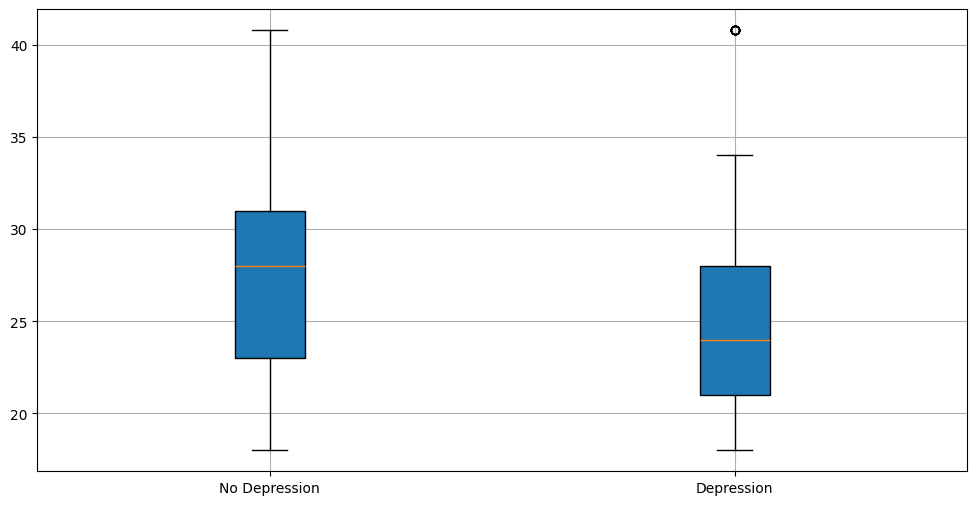

In [ ]:
df.loc[df['Age']>=35, 'Age'] = df[df['Age']>=35]['Age'].mean()
fig = plt.figure(figsize = (12,6))
df_not_depression = df[df['Depression']==0]
df_depression = df[df['Depression']==1]

data = [df_not_depression['Age'], df_depression['Age']]
plt.boxplot(data, patch_artist=True, labels=['No Depression', 'Depression'])
plt.grid()
plt.show()

In [ ]:
print(df['Age'].value_counts().sort_values())

Age
40.795918      49
30.000000    1145
26.000000    1155
22.000000    1160
32.000000    1262
31.000000    1427
27.000000    1462
34.000000    1468
19.000000    1560
18.000000    1587
23.000000    1645
21.000000    1726
25.000000    1784
33.000000    1893
29.000000    1950
28.000000    2133
20.000000    2237
24.000000    2258
Name: count, dtype: int64


In [ ]:
df.groupby(['Depression'], as_index=False).agg({'Age':['mean', 'max', 'min']})

Depression        Age                 
                   mean        max   min
0          0  27.141691  40.795918  18.0
1          1  24.888244  40.795918  18.0

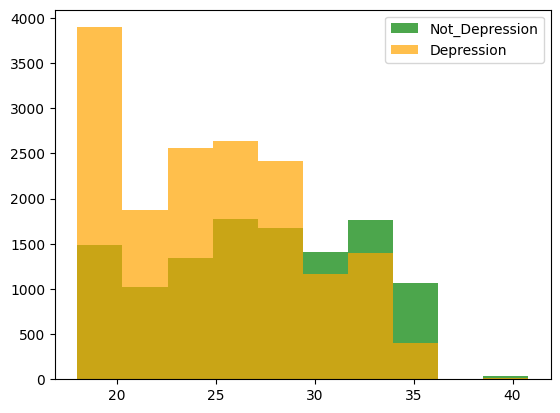

In [ ]:
plt.hist(df[df['Depression']==0]['Age'], label = 'Not_Depression', color = 'green', alpha = 0.7)
plt.hist(df[df['Depression']==1]['Age'], label = 'Depression', color = 'orange', alpha = 0.7)
plt.legend()
plt.show()

Посмотрим на столбец CGPA, если количество записей по значению меньше 30 будем искать ближайшее значение среди более популярных значений

In [ ]:
df_CGPA = df['CGPA'].value_counts()
print(len(df_CGPA[df_CGPA<=30]), len(df_CGPA))

df_CGPA_small = df_CGPA[df_CGPA<=30].index
df_CGPA_big = df_CGPA[df_CGPA>30].index


69 332


In [ ]:
for i in df_CGPA_small:
  diff = df_CGPA_big - i
  ind = np.argmin(np.array(diff))
  df.loc[df['CGPA'] == i, 'CGPA'] = df_CGPA_big[ind]

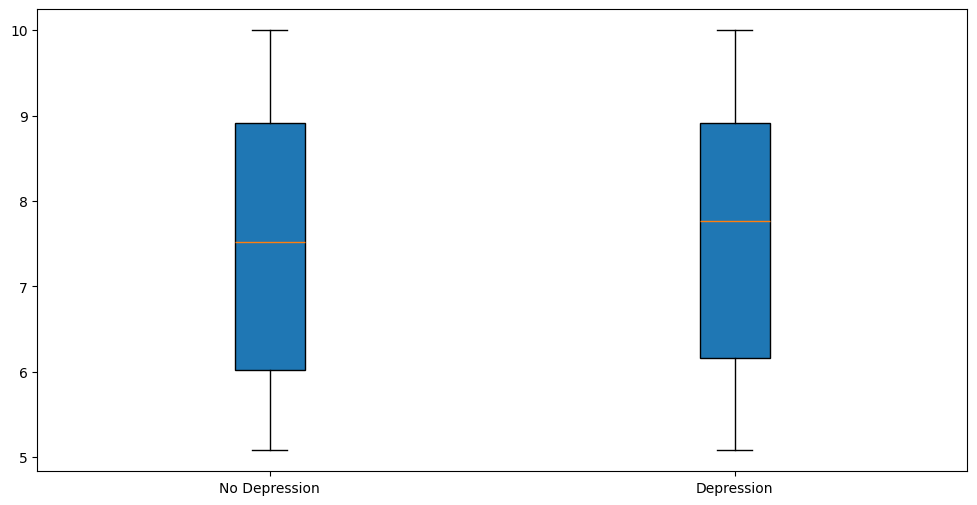

In [ ]:
fig = plt.figure(figsize = (12,6))
df_not_depression = df[df['Depression']==0]
df_depression = df[df['Depression']==1]

data = [df_not_depression['CGPA'], df_depression['CGPA']]
plt.boxplot(data, patch_artist=True, labels=['No Depression', 'Depression'])
plt.show()

In [ ]:
df.groupby(['Depression'], as_index=False).agg({'CGPA':['mean', 'max', 'min']})

Depression      CGPA            
                  mean   max   min
0          0  7.523506  10.0  5.08
1          1  7.584428  10.0  5.08

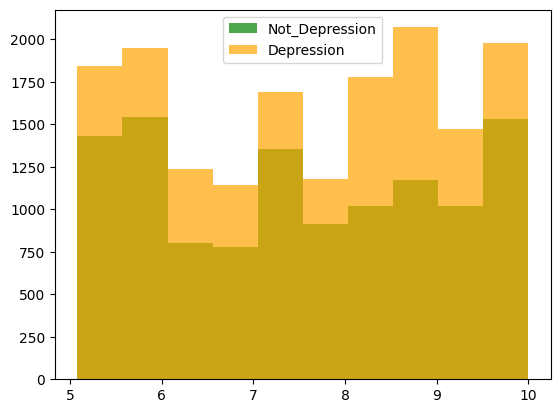

In [ ]:
plt.hist(df[df['Depression']==0]['CGPA'], label = 'Not_Depression', color = 'green', alpha = 0.7)
plt.hist(df[df['Depression']==1]['CGPA'], label = 'Depression', color = 'orange', alpha = 0.7)
plt.legend()
plt.show()

По гистограммам также видно, что количество нулей в таких признаках как Study_Satisfaction, 'Academic_Pressure' мало нулей. Заменим нули на единицы

(array([5461.,    0., 5838.,    0.,    0., 5821.,    0., 6359.,    0.,
        4422.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

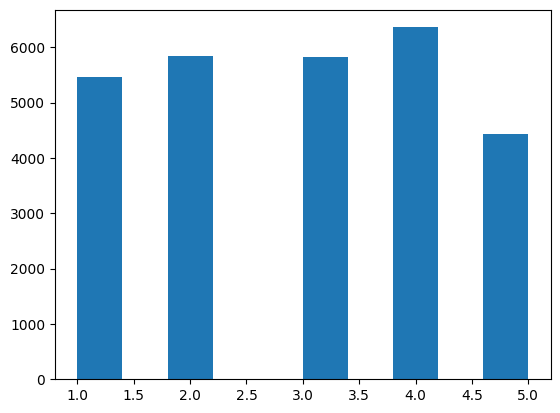

In [ ]:
df.loc[df['Study_Satisfaction']==0, 'Study_Satisfaction'] = 1.0
plt.hist(df['Study_Satisfaction'])

In [ ]:
df.groupby(['Depression'], as_index=False).agg({'Study_Satisfaction':['mean', 'median', 'max', 'min']})

Depression Study_Satisfaction                 
                           mean median  max  min
0          0           3.215910    3.0  5.0  1.0
1          1           2.751836    3.0  5.0  1.0

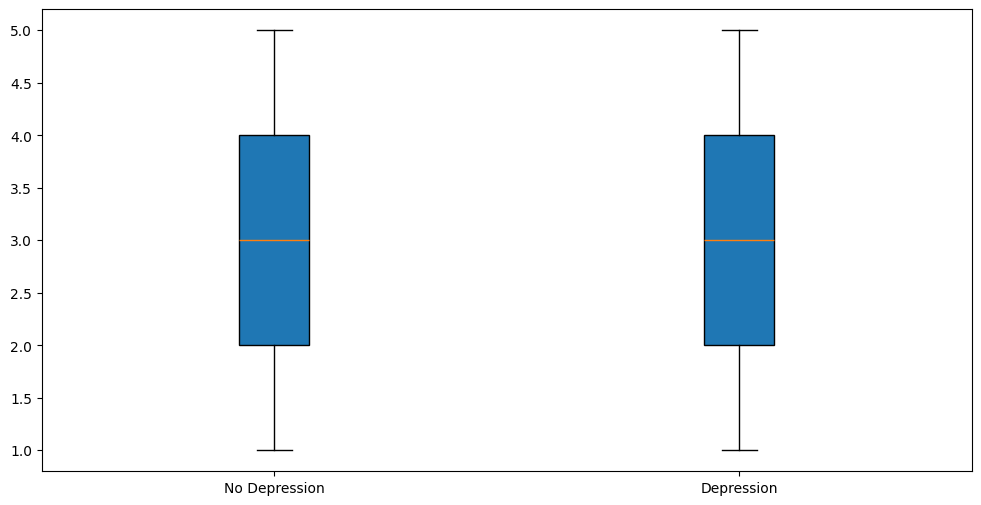

In [ ]:
fig = plt.figure(figsize = (12,6))
df_not_depression = df[df['Depression']==0]
df_depression = df[df['Depression']==1]

data = [df_not_depression['Study_Satisfaction'], df_depression['Study_Satisfaction']]
plt.boxplot(data, patch_artist=True, labels=['No Depression', 'Depression'])
plt.show()

Аналогично с удовлетворенностью обучением

(array([4810.,    0., 4178.,    0.,    0., 7462.,    0., 5155.,    0.,
        6296.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

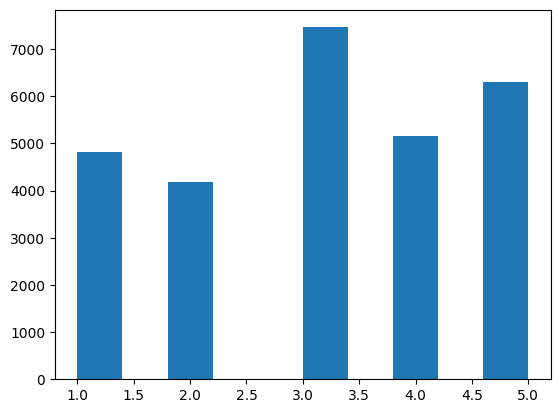

In [ ]:
df.loc[df['Academic_Pressure']==0, 'Academic_Pressure'] = 1.0
plt.hist(df['Academic_Pressure'])

In [ ]:
df.groupby(['Depression'], as_index=False).agg({'Academic_Pressure':['mean', 'median', 'max', 'min']})

Depression Academic_Pressure                 
                          mean median  max  min
0          0          2.362041    2.0  5.0  1.0
1          1          3.693377    4.0  5.0  1.0

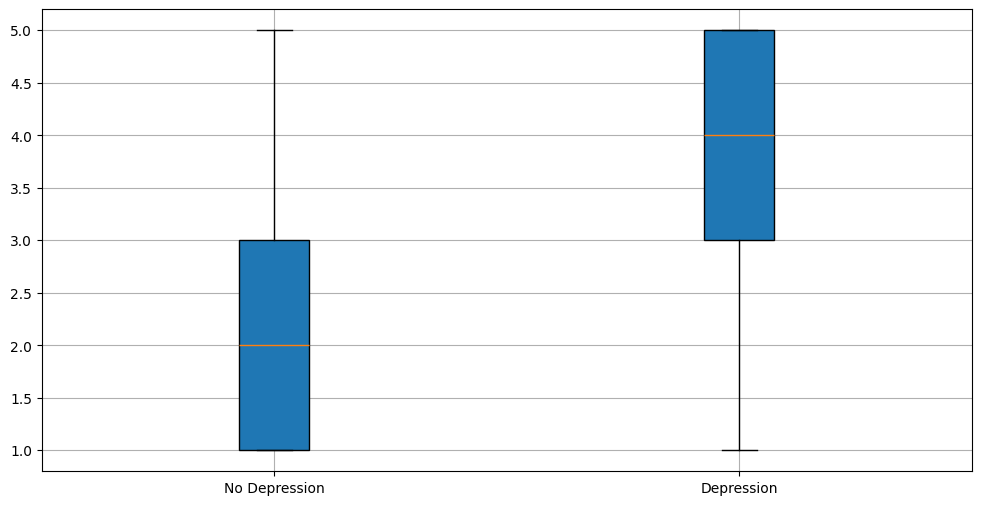

In [ ]:
fig = plt.figure(figsize = (12,6))
df_not_depression = df[df['Depression']==0]
df_depression = df[df['Depression']==1]

data = [df_not_depression['Academic_Pressure'], df_depression['Academic_Pressure']]
plt.boxplot(data, patch_artist=True, labels=['No Depression', 'Depression'])
plt.grid()
plt.show()

In [ ]:
df.head()

,id,Gender,Age,City,Academic_Pressure,CGPA,Study_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Have_you_ever_had_suicidal_thoughts_,Work_Study_Hours,Financial_Stress,Family_History_of_Mental_Illness,Depression
0,2,1,33.0,Visakhapatnam,5.0,8.97,2.0,'5-6 hours',Healthy,B.Pharm,1,3.0,1.0,0,1
1,8,0,24.0,Bangalore,2.0,5.90,5.0,'5-6 hours',Moderate,BSc,0,3.0,2.0,1,0
2,26,1,31.0,Srinagar,3.0,7.03,5.0,'Less than 5 hours',Healthy,BA,0,9.0,1.0,1,0
3,30,0,28.0,Varanasi,3.0,5.59,2.0,'7-8 hours',Moderate,BCA,1,4.0,5.0,1,1
4,32,0,25.0,Jaipur,4.0,8.13,3.0,'5-6 hours',Moderate,M.Tech,1,1.0,1.0,0,0


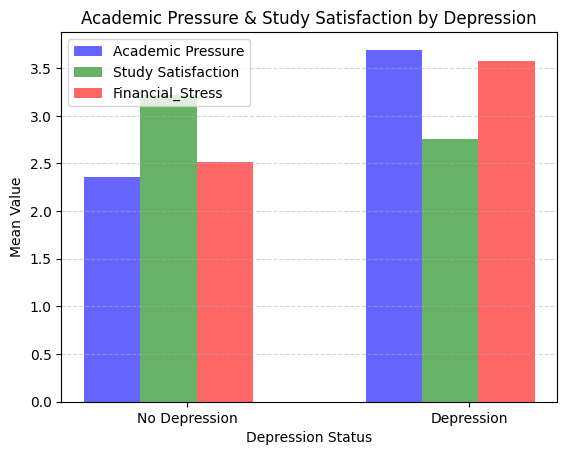

In [ ]:
Age_Satisfaction = df.groupby(['Depression'], as_index=False).agg({'Study_Satisfaction':['mean', 'median', 'max', 'min']})
Age_Pressure = df.groupby(['Depression'], as_index=False).agg({'Academic_Pressure':['mean', 'median', 'max', 'min']})
Financial_Stress = df.groupby(['Depression'], as_index=False).agg({'Financial_Stress':['mean', 'median', 'max', 'min']})


x = Age_Pressure['Depression']
pressure_means = Age_Pressure['Academic_Pressure']['mean']
satisfaction_means = Age_Satisfaction['Study_Satisfaction']['mean']
finances_stress_mean = Financial_Stress['Financial_Stress']['mean']

bar_width = 0.2
x_pos = np.arange(len(x))

plt.bar(x_pos - 4*bar_width/3, pressure_means, width=bar_width, label='Academic Pressure', color='blue', alpha=0.6)
plt.bar(x_pos - bar_width/3, satisfaction_means, width=bar_width, label='Study Satisfaction', color='green', alpha=0.6)
plt.bar(x_pos + 2*bar_width/3, finances_stress_mean, width=bar_width, label='Financial_Stress', color='red', alpha=0.6)

plt.xticks(x_pos, ['No Depression', 'Depression'])
plt.xlabel('Depression Status')
plt.ylabel('Mean Value')
plt.title('Academic Pressure & Study Satisfaction by Depression')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

На исходном графике виден также дисбаланс по столбцу City, запишем также все города, значений по которым меньше 10 запишем в одно значение Other

In [ ]:
city = df['City'].value_counts()
small_count = city[city < 10]

<Axes: xlabel='City'>

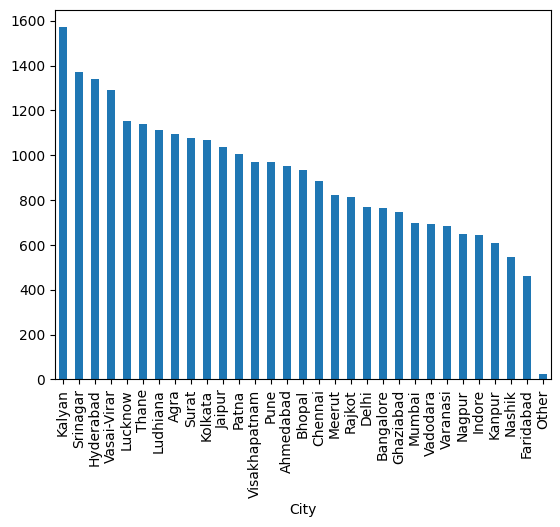

In [ ]:
df.loc[df['City'].isin(small_count.index), 'City'] = 'Other'
df['City'].value_counts().plot(kind='bar')

Посмотрим также на признаки 'Sleep_Duration', 'Dietary_Habits'. Запишем очень непопярную категорию Other в самую популярную.

In [ ]:
df['Sleep_Duration'].value_counts()

,count
Sleep_Duration,
'Less than 5 hours',8310
'7-8 hours',7346
'5-6 hours',6183
'More than 8 hours',6044
Others,18


In [ ]:
df.loc[df['Sleep_Duration'] == 'Others', 'Sleep_Duration'] = "'Less than 5 hours'"

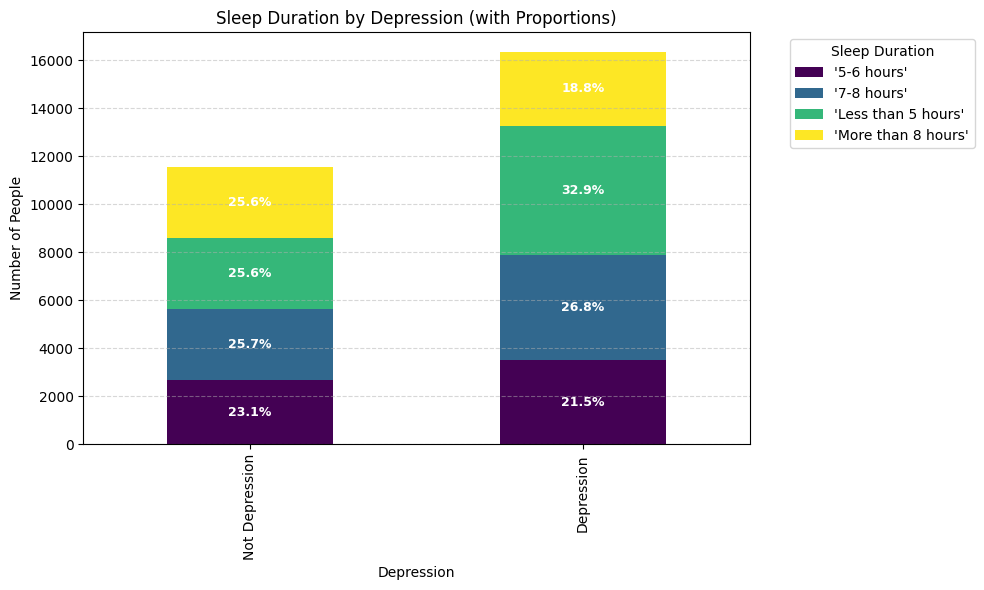

In [ ]:
crosstab_abs = pd.crosstab(df['Depression'], df['Sleep_Duration'])

# доли
crosstab_pct = crosstab_abs.div(crosstab_abs.sum(axis=1), axis=0)

ax = crosstab_abs.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Добавление аннотаций с долями в процентах
for i, (index, row) in enumerate(crosstab_abs.iterrows()):
    cum_sum = 0
    for col in crosstab_abs.columns:
        height = row[col]
        if height > 0:
            percentage = crosstab_pct.loc[index, col] * 100
            ax.text(i, cum_sum + height / 2, f'{percentage:.1f}%',
                    ha='center', va='center', fontsize=9, color='white', fontweight='bold')
            cum_sum += height

# Настройки графика
plt.title('Sleep Duration by Depression (with Proportions)')
plt.xlabel('Depression')
plt.ylabel('Number of People')
plt.xticks(ticks=[0, 1], labels=['Not Depression', 'Depression'])
plt.legend(title='Sleep Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
df['Dietary_Habits'].value_counts()

,count
Dietary_Habits,
Unhealthy,10317
Moderate,9921
Healthy,7651
Others,12


In [ ]:
df.loc[df['Dietary_Habits'] == 'Others', 'Dietary_Habits'] = "Unhealthy"

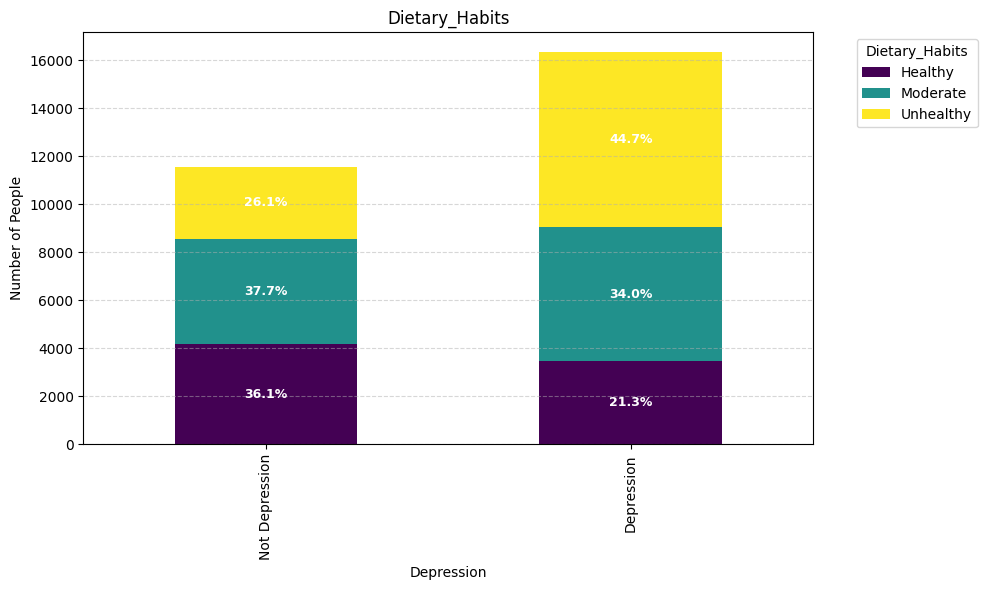

In [ ]:
crosstab_abs = pd.crosstab(df['Depression'], df['Dietary_Habits'])

# доли
crosstab_pct = crosstab_abs.div(crosstab_abs.sum(axis=1), axis=0)

ax = crosstab_abs.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

for i, (index, row) in enumerate(crosstab_abs.iterrows()):
    cum_sum = 0
    for col in crosstab_abs.columns:
        height = row[col]
        if height > 0:
            percentage = crosstab_pct.loc[index, col] * 100
            ax.text(i, cum_sum + height / 2, f'{percentage:.1f}%',
                    ha='center', va='center', fontsize=9, color='white', fontweight='bold')
            cum_sum += height

# Настройки графика
plt.title('Dietary_Habits')
plt.xlabel('Depression')
plt.ylabel('Number of People')
plt.xticks(ticks=[0, 1], labels=['Not Depression', 'Depression'])
plt.legend(title='Dietary_Habits', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Посмотрим на корреляции

<Axes: >

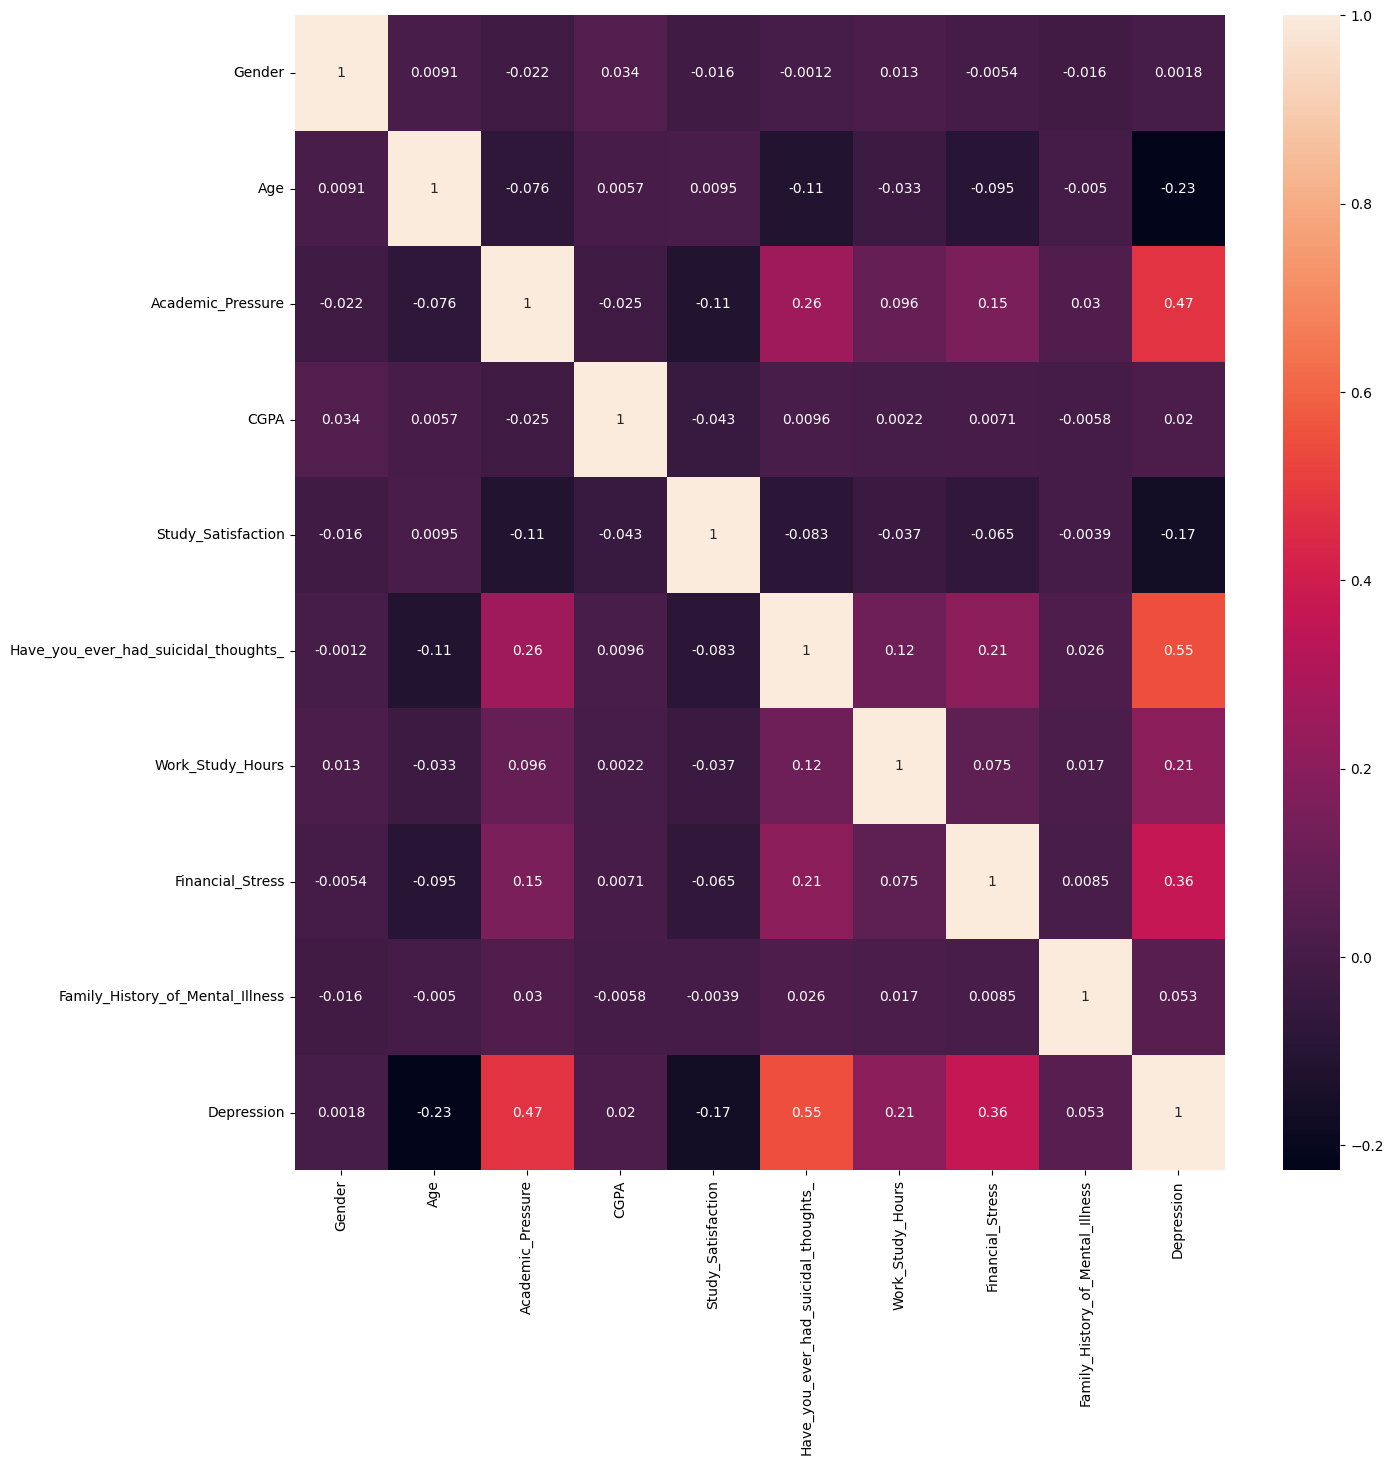

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(df[num_col].corr(), annot = True)

Исследуем следующие гипотезы:

- Средний балл (CGPA) у мужчин и женщин не отличается.

- Удовлетворенность учебой у людей разных возрастных групп не одинакова. Выше удовлетворенность учебой, чем у тех, кто старше 30, самая низкая у тех, кто младше 20.  

- Привычки питания связаны с наличием депрессии

- Доля наличия депрессии больше людей, с финансовым стрессом 4-5, чем с фин. стрессом 2-3

- Город проживанияи и пол (или их комбинация) не влияют на наличие депрессии






In [ ]:
#проверка равенства дисперсий
def levene(data_1, data_2):
  stats_lev, pvalue = stats.levene(data_1, data_2)
  return pvalue

In [ ]:
#равенство средних двух выборок
def t_test(data_1, data_2):
  #проверим равенство дисперсий
  pvalue = levene(data_1, data_2)
  if pvalue < 0.05:
    t_stats, t_pvalue = stats.ttest_ind(data_1, data_2, random_state=42)
  else:
    t_stats, t_pvalue = stats.ttest_ind(data_1, data_2, random_state=42, equal_var = False)

  return t_pvalue

In [ ]:
#H0: у мужчин и женщин средний CGPA не отличается t-test
from scipy import stats

mean_CGPA_male = np.array(df[df['Gender']==1]['CGPA'])
mean_CGPA_female = np.array(df[df['Gender']==0]['CGPA'])

t_pvalue = t_test(mean_CGPA_male, mean_CGPA_female)

if t_pvalue < 0.05:
    print("Отклоняем нулевую гипотезу: существует значительная разница между группами.")
else:
    print("Не отклоняем нулевую гипотезу: разницы между группами нет.")


Отклоняем нулевую гипотезу: существует значительная разница между группами.


In [ ]:
#проверка на нормальность
def test_norm(data, n_simulations=1000):
    def statistic(x):
        return stats.shapiro(x)[0]

    stat_values = [
        statistic(np.random.normal(loc=np.mean(data), scale=np.std(data), size=len(data)))
        for _ in range(n_simulations)
    ]

    stat_data = statistic(data)
    p_value = np.sum(stat_values <= stat_data)/n_simulations

    return p_value

In [ ]:
#равенство средних нескольких групп
def mean_more_two(*args, value_H0):
  counter = 0
  for group in args:
    p_val = test_norm(group)
    if p_val < value_H0:
      counter += 1
  if counter == 0:
    f_stat, p_val = stats.f_oneway(*args)
    print("Параметрический тест")

  else:
    f_stat, p_val = stats.kruskal(*args)
    print("Непараметрический тест")

  return p_val

In [ ]:
#H0: у трех возрастных групп среднее не отличается (меньше 20, между 20 и 30, больше 30) ANOVA/непараметрический ANOVA
#проверим распредление данных
mean_study_satisfaction_less_20 = np.array(df[df['Age']<=20]['Study_Satisfaction'])
mean_study_satisfaction_more_20_less_30 = np.array(df[(df['Age']>20) & (df['Age']<30)]['Study_Satisfaction'])
mean_study_satisfaction_more_30 = np.array(df[df['Age']>=30]['Study_Satisfaction'])

p_val = mean_more_two(mean_study_satisfaction_less_20, mean_study_satisfaction_more_20_less_30, mean_study_satisfaction_more_30, value_H0 = 0.05)

if p_val < 0.05:
    print("Отклоняем нулевую гипотезу: существует значительная разница между группами.")
else:
    print("Не отклоняем нулевую гипотезу: разницы между группами нет.")

Непараметрический тест
Отклоняем нулевую гипотезу: существует значительная разница между группами.


In [ ]:
# увидели, что есть статистическое различие, посмотрим тогда в каких конкретно группах
from statsmodels.stats.multicomp import pairwise_tukeyhsd

data = np.concatenate([
    mean_study_satisfaction_less_20,
    mean_study_satisfaction_more_20_less_30,
    mean_study_satisfaction_more_30
])
labels = ['less_20'] * len(mean_study_satisfaction_less_20) + ['more_20_less_30'] * len(mean_study_satisfaction_more_20_less_30) + ['more_30'] * len(mean_study_satisfaction_more_30)

tukey_result = pairwise_tukeyhsd(data, labels)

print(tukey_result)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
        less_20 more_20_less_30  -0.2236    0.0  -0.274 -0.1732   True
        less_20         more_30  -0.0862 0.0012 -0.1435  -0.029   True
more_20_less_30         more_30   0.1374    0.0   0.092  0.1828   True
----------------------------------------------------------------------


In [ ]:
summary_df = pd.DataFrame(tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])
for i in range(len(summary_df)):
  if summary_df.iloc[i]['reject'] == True:
    print(f"Группы {summary_df.iloc[i]['group1']} и {summary_df.iloc[i]['group2']} имеют статистические различия в среднем")
  else:
    print(f"Группы {summary_df.iloc[i]['group1']} и {summary_df.iloc[i]['group2']} не имеют статистические различия в среднем")


Группы less_20 и more_20_less_30 имеют статистические различия в среднем
Группы less_20 и more_30 имеют статистические различия в среднем
Группы more_20_less_30 и more_30 имеют статистические различия в среднем


In [ ]:
#таблица сопреженности
#в дату передаем массив массивов - количество массивов это количество индексов, количество элементов в каждом массиве - количество столбцов
def contingency_table(columns, index, data):
  table = pd.DataFrame(data, columns=columns, index = index)
  return table


In [ ]:
def chisquare(columns, index, data):
  table = contingency_table(columns, index, data)
  chi2_stat, p_value, dof, expected = stats.chi2_contingency(table)
  return p_value


In [ ]:
#H0: привычки питания не связаны с наличием депрессии хи-квадрат
Dietary_Habits = np.unique(df['Dietary_Habits'])
table_group = df.groupby(['Dietary_Habits', 'Depression'], as_index=False).agg({'id':'count'})
data = []
for habit in Dietary_Habits:
  data.append(np.array(table_group[table_group['Dietary_Habits'] == habit]['id']))
pval = chisquare(np.unique(df['Depression']), Dietary_Habits, data)

if pval < 0.05:
    print("Отклоняем нулевую гипотезу: переменные зависимы.")
else:
    print("Не отклоняем нулевую гипотезу: переменные независимы.")

Отклоняем нулевую гипотезу: переменные зависимы.


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

def z_test_part(data_1, data_2):
  count_one = [int(len(data_1[data_1==1])), int(len(data_2[data_2==1]))] #количество успехов в 1 и 2 группе
  count_all = [int(len(data_1)), int(len(data_2))] #общее количество в группах

  stat, p_value = proportions_ztest(count_one, count_all, alternative='smaller')

  return stat, p_value

In [ ]:
#H0: Доли наличия депрессии равны у людей, с финансовым стрессом 4-5, чем с фин. стрессом 2-3

df_fin_stress_2_or_3 = df[(df['Financial_Stress']==2) | (df['Financial_Stress']==3)]['Depression']
df_fin_stress_4_or_5 = df[(df['Financial_Stress']==4) | (df['Financial_Stress']==5)]['Depression']

stat, pval = z_test_part( df_fin_stress_2_or_3, df_fin_stress_4_or_5)

if pval < 0.05:
    print("Отклоняем нулевую гипотезу: доля наличия депрессии больше у людей, с финансовым стрессом 4-5, чем с фин. стрессом 2-3.")
else:
    print("Не отклоняем нулевую гипотезу: доли наличия депрессии равны у людей с разным финансовым стрессом.")

Отклоняем нулевую гипотезу: доля наличия депрессии больше у людей, с финансовым стрессом 4-5, чем с фин. стрессом 2-3.


In [ ]:
#Город проживанияи и пол (или их комбинация) не влияют на наличие депрессии
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

data = df[['City', 'Age', 'Depression']]
model = ols('Depression ~ C(City) + Age + C(City):Age', data=data).fit()

dictionary = {'C(City)': 'город', 'Age': 'возраст', 'C(City):Age': 'комбинация возраста и города'}
anova_result = anova_lm(model)
anova_result = pd.DataFrame(anova_result)

for num_str in range(len(anova_result) - 1):
  str_ = anova_result.iloc[num_str].T
  if float(str_['PR(>F)']) < 0.05:
    print(f"Фактор {dictionary[str(str_.name)]} имеет значимое влияние на наличие депрессии")
  else:
    print(f"Фактор {dictionary[str(str_.name)]} не имеет значимого влияние на наличие депрессии")


Фактор город имеет значимое влияние на наличие депрессии
Фактор возраст имеет значимое влияние на наличие депрессии
Фактор комбинация возраста и города имеет значимое влияние на наличие депрессии


Генерим новые переменные

In [ ]:
#новые переменная по академическим переменным
#группы по учебе: Academic Pressure и CGPA
#print(df['Academic Pressure'].unique())
df['Cat_Academic_Pressure'] = 'Excellent'
df.loc[(df['Academic_Pressure'] == 4.0) | (df['Academic_Pressure'] == 3.0), 'Cat_Academic_Pressure'] = 'Normal'
df.loc[(df['Academic_Pressure'] == 2.0) | (df['Academic_Pressure'] == 1.0), 'Cat_Academic_Pressure'] = 'Bad'

df['Cat_Satisfaction'] = 'Excellent'
df.loc[(df['Study_Satisfaction'] == 4.0) | (df['Study_Satisfaction'] == 3.0), 'Cat_Satisfaction'] = 'Normal'
df.loc[(df['Study_Satisfaction'] == 2.0) | (df['Study_Satisfaction'] == 1.0), 'Cat_Satisfaction'] = 'Bad'

df['Cat_CGPA'] = 'Excellent'
df.loc[(df['CGPA'] < 8.0) & (df['CGPA'] >= 6.0), 'Cat_CGPA'] = 'Good'
df.loc[(df['CGPA'] < 6.0) & (df['CGPA'] >= 4.0), 'Cat_CGPA'] = 'Normal'
df.loc[(df['CGPA'] < 4.0) & (df['CGPA'] >= 0.0), 'Cat_CGPA'] = 'Bad'

df['Cat_Study'] = df['Cat_Academic_Pressure'] + '+' + df['Cat_CGPA']
df['Cat_Study'].value_counts()

,count
Cat_Study,
Normal+Excellent,5529
Normal+Good,4242
Bad+Excellent,3904
Bad+Good,3094
Normal+Normal,2846
Excellent+Excellent,2713
Excellent+Good,2080
Bad+Normal,1990
Excellent+Normal,1503


In [ ]:
#вот тут уже полностью по учебе
df.loc[df['Cat_Study'] == 'Bad+Bad', 'Cat_Study'] = 'Bad+Normal'
df.loc[df['Cat_Study'] == 'Normal+Bad', 'Cat_Study'] = 'Normal+Normal'
df.loc[df['Cat_Study'] == 'Excellent+Bad', 'Cat_Study'] = 'Excellent+Normal'
df['Cat_Study'].value_counts()

,count
Cat_Study,
Normal+Excellent,5529
Normal+Good,4242
Bad+Excellent,3904
Bad+Good,3094
Normal+Normal,2846
Excellent+Excellent,2713
Excellent+Good,2080
Bad+Normal,1990
Excellent+Normal,1503


In [ ]:
df['Cat_Study_Satisfaction'] = df['Cat_Academic_Pressure'] + '+' + df['Cat_Satisfaction']
df['Cat_Study_Satisfaction'].value_counts()

,count
Cat_Study_Satisfaction,
Normal+Normal,5670
Normal+Bad,5122
Bad+Normal,4283
Excellent+Bad,3211
Bad+Bad,2966
Excellent+Normal,2227
Normal+Excellent,1825
Bad+Excellent,1739
Excellent+Excellent,858


In [ ]:
df['Cat_All_Study'] = df['Cat_Academic_Pressure'] + '+' + df['Cat_CGPA'] + '+' + df['Cat_Satisfaction']
print(df['Cat_All_Study'].value_counts())
print(df['Cat_All_Study'].value_counts().shape)

Cat_All_Study
Normal+Excellent+Normal          2463
Normal+Excellent+Bad             2359
Normal+Good+Normal               1973
Bad+Excellent+Normal             1848
Normal+Good+Bad                  1667
Excellent+Excellent+Bad          1477
Bad+Good+Normal                  1475
Bad+Excellent+Bad                1338
Normal+Normal+Normal             1234
Normal+Normal+Bad                1096
Bad+Good+Bad                     1022
Excellent+Good+Bad               1001
Bad+Normal+Normal                 960
Excellent+Excellent+Normal        919
Excellent+Good+Normal             768
Excellent+Normal+Bad              733
Bad+Excellent+Excellent           718
Normal+Excellent+Excellent        707
Bad+Normal+Bad                    606
Normal+Good+Excellent             602
Bad+Good+Excellent                597
Excellent+Normal+Normal           540
Normal+Normal+Excellent           516
Bad+Normal+Excellent              424
Excellent+Excellent+Excellent     317
Excellent+Good+Excellent          31

In [ ]:
df.loc[df['Cat_All_Study'] == 'Bad+Bad+Bad', 'Cat_All_Study'] = 'Bad+Normal+Bad'
df.loc[df['Cat_All_Study'] == 'Normal+Bad+Normal', 'Cat_All_Study'] = 'Normal+Normal+Normal'
df.loc[df['Cat_All_Study'] == 'Excellent+Bad+Bad', 'Cat_All_Study'] = 'Excellent+Normal+Bad'
df.loc[df['Cat_All_Study'] == 'Bad+Bad+Excellent', 'Cat_All_Study'] = 'Bad+Normal+Excellent'
df['Cat_All_Study'].value_counts().shape

(27,)

In [ ]:
df['Cat_Work_Study_Hours'] = 'Long_time_study'
df.loc[(df['Work_Study_Hours'] == 4.0) | (df['Work_Study_Hours'] == 3.0), 'Cat_Work_Study_Hours'] = 'Normal_time_study'
df.loc[(df['Work_Study_Hours'] == 2.0) | (df['Work_Study_Hours'] == 1.0), 'Cat_Work_Study_Hours'] = 'Short_time_study'

df['Cat_Financial_Stress'] = 'Strong_Stress'
df.loc[(df['Financial_Stress'] == 3.0), 'Cat_Financial_Stress'] = 'Normal_Stress'
df.loc[(df['Financial_Stress'] == 2.0) | (df['Financial_Stress'] == 1.0), 'Cat_Financial_Stress'] = 'Small_Stress'

df['Lifestyle'] = df['Dietary_Habits'] + '+' + df['Sleep_Duration'] + '+' + df['Cat_Work_Study_Hours']
df['Cat_time_sucsess_study'] = df['Cat_Academic_Pressure'] + df['Cat_Work_Study_Hours']
df['Cat_prof_money'] = df['Cat_Financial_Stress'] + '+' + df['Degree']



In [ ]:
df['Cat_Age'] = 'Old'
df.loc[(df['Age'] < 33) & (df['Age'] >= 25), 'Cat_Age'] = 'Adult'
df.loc[df['Age'] < 25, 'Cat_Age'] = 'Young'

df['Cat_Age_money'] = df['Cat_Age'] + '+' + df['Cat_Financial_Stress']

In [ ]:
df = df.drop(['id'], axis = 1)
df.head(5)

,Gender,Age,City,Academic_Pressure,CGPA,Study_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Have_you_ever_had_suicidal_thoughts_,...,Cat_Study,Cat_Study_Satisfaction,Cat_All_Study,Cat_Work_Study_Hours,Cat_Financial_Stress,Lifestyle,Cat_time_sucsess_study,Cat_prof_money,Cat_Age,Cat_Age_money
0,1,33.0,Visakhapatnam,5.0,8.97,2.0,'5-6 hours',Healthy,B.Pharm,1,...,Excellent+Excellent,Excellent+Bad,Excellent+Excellent+Bad,Normal_time_study,Small_Stress,Healthy+'5-6 hours'+Normal_time_study,ExcellentNormal_time_study,Small_Stress+B.Pharm,Old,Old+Small_Stress
1,0,24.0,Bangalore,2.0,5.90,5.0,'5-6 hours',Moderate,BSc,0,...,Bad+Normal,Bad+Excellent,Bad+Normal+Excellent,Normal_time_study,Small_Stress,Moderate+'5-6 hours'+Normal_time_study,BadNormal_time_study,Small_Stress+BSc,Young,Young+Small_Stress
2,1,31.0,Srinagar,3.0,7.03,5.0,'Less than 5 hours',Healthy,BA,0,...,Normal+Good,Normal+Excellent,Normal+Good+Excellent,Long_time_study,Small_Stress,Healthy+'Less than 5 hours'+Long_time_study,NormalLong_time_study,Small_Stress+BA,Adult,Adult+Small_Stress
3,0,28.0,Varanasi,3.0,5.59,2.0,'7-8 hours',Moderate,BCA,1,...,Normal+Normal,Normal+Bad,Normal+Normal+Bad,Normal_time_study,Strong_Stress,Moderate+'7-8 hours'+Normal_time_study,NormalNormal_time_study,Strong_Stress+BCA,Adult,Adult+Strong_Stress
4,0,25.0,Jaipur,4.0,8.13,3.0,'5-6 hours',Moderate,M.Tech,1,...,Normal+Excellent,Normal+Normal,Normal+Excellent+Normal,Short_time_study,Small_Stress,Moderate+'5-6 hours'+Short_time_study,NormalShort_time_study,Small_Stress+M.Tech,Adult,Adult+Small_Stress


In [ ]:
num_col = ['Age', 'CGPA', 'Work_Study_Hours']
target = ['Depression']
cat_col = [x for x in df.columns if x not in ['Age', 'CGPA', 'Work_Study_Hours', 'Depression']]

In [ ]:
df[cat_col] = df[cat_col].astype('object')

In [ ]:
target = df['Depression']
df = df.drop(columns='Depression')
train, test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

Подготовка данных. Обработка через стандарт скэйлер и one hot encoder

In [ ]:
# transformer = make_column_transformer((StandardScaler(), num_col),
#                                       (OneHotEncoder(handle_unknown='ignore'), cat_col))

# X_train = transformer.fit_transform(train)
# X_test = transformer.transform(test)

scaler = StandardScaler()
train_num_scaled = pd.DataFrame(scaler.fit_transform(train[num_col]), columns=num_col)
test_num_scaled = pd.DataFrame(scaler.transform(test[num_col]), columns=num_col)

In [ ]:
train_cat_dummies = pd.get_dummies(train[cat_col], drop_first=False)  # drop_first=True — для избежания мультиколлинеарности
test_cat_dummies = pd.get_dummies(test[cat_col], drop_first=False)

train_cat_dummies, test_cat_dummies = train_cat_dummies.align(test_cat_dummies, join='left', axis=1, fill_value=0)

X_train_df = pd.concat([train_num_scaled.reset_index(drop=True),
                        train_cat_dummies.reset_index(drop=True).astype(int)], axis=1)

X_test_df = pd.concat([test_num_scaled.reset_index(drop=True),
                       test_cat_dummies.reset_index(drop=True).astype(int)], axis=1)

Здесь буду обрабатывать через стандарт скэйлер и с помощью среднего значения таргетов по категориям  

In [ ]:
scaler = StandardScaler()
train_num_scaled = pd.DataFrame(scaler.fit_transform(train[num_col]), columns=num_col)
test_num_scaled = pd.DataFrame(scaler.transform(test[num_col]), columns=num_col)

In [ ]:
def TargetEncoder(train, test, y_train): #здесь уже надо подавать категориальную часть
  cols = train.columns
  train_with_target = train.join(y_train)
  y_train_mean = y_train.mean()
  for col in cols:
    group_by_col = train_with_target.groupby(col).agg({y_train.name: 'mean'}).squeeze()
    train[col] = train[col].map(group_by_col)
    test[col] = test[col].map(group_by_col).fillna(y_train_mean)

  return train, test

In [ ]:
train_cat, test_cat = TargetEncoder(train[cat_col], test[cat_col], y_train)

X_train_df = pd.concat([train_num_scaled.reset_index(drop=True),
                        train_cat.reset_index(drop=True)], axis=1)

X_test_df = pd.concat([test_num_scaled.reset_index(drop=True),
                       test_cat.reset_index(drop=True)], axis=1)

Отбор фич

In [ ]:
# отбор по корреляциям,
def features_selection_filtr(features, target, part_null = 0.7, part_corr = 0.7, amount_best_features = 20):

  def stat(x):
    return pd.Series(x.isnull().sum())

  stat = features.apply(stat).T
  stat.columns = ['amount_null']
  min_null = len(features)*part_null
  stat_leaves = stat[(stat < min_null).any(axis=1) | stat.isna().any(axis=1)]
  variables_leaves = np.array(stat_leaves.index)
  features = features[variables_leaves]

  # data = pd.DataFrame(columns=['features', 'correlation'])

  # for col in features.columns:
  #     corr = np.abs(features[col].corr(target))
  #     data = pd.concat([data, pd.DataFrame({'features': [col], 'correlation': [corr]})],
  #                     ignore_index=True)
  # data = data.dropna()
  # data.sort_values(by = 'correlation', ascending=False)
  # data = data.set_index('features')

  #вот здесь по джини, выше по корреляции надо что-то комментить
  data = pd.DataFrame(columns=['features', 'gini'])

  for col in features.columns:
      gini = 2* roc_auc_score(target, features[col]) - 1
      data = pd.concat([data, pd.DataFrame({'features': [col], 'gini': [gini]})],
                      ignore_index=True)
  data = data.dropna()
  data.sort_values(by = 'gini', ascending=False)
  data = data.set_index('features')

  corr_matrix = abs(features.corr()).stack().reset_index()
  corr_matrix.columns = ['feature_1', 'feature_2', 'correlation']
  corr_matrix = corr_matrix[corr_matrix['feature_1'] < corr_matrix['feature_2']]

  list_to_drop = []
  corr_matrix = corr_matrix.dropna()
  for i in range(len(corr_matrix)):
    if corr_matrix.iloc[i]['correlation']>=part_corr:
      f1 = corr_matrix.iloc[i]['feature_1']
      f2 = corr_matrix.iloc[i]['feature_2']
      if f1 in data.index and f2 in data.index:
        if float(data.loc[f1]) >= float(data.loc[f2]):
          list_to_drop.append(f2)
        else:
          list_to_drop.append(f1)
      elif f1 not in data.index:
        list_to_drop.append(f1)
      elif f2 not in data.index:
        list_to_drop.append(f2)
      else:
        list_to_drop.append(f2)
        list_to_drop.append(f1)

  list_to_drop = set(list_to_drop)

  variables = [i for i in np.array(data.index) if i not in list_to_drop]

  # data = data.loc[variables].sort_values(by = 'correlation', ascending=False)#.head(amount_best_features)
  data = data.loc[variables].sort_values(by = 'gini', ascending=False)#.head(amount_best_features)

  variables = np.array(data.index)

  return variables

In [ ]:
variables_first = features_selection_filtr(X_train_df, y_train)
X_train_df = X_train_df[variables_first]
X_test_df = X_test_df[variables_first]

In [ ]:
#модельный отбор и target permutation

def feature_selection_model(features, target, test_size = 0.2):
  clf = xgb.XGBClassifier(eval_metric = 'auc',
                          random_state = 42)
  clf.fit(features, target)
  importances =clf.feature_importances_

  feature_importance_df = pd.DataFrame({
    'feature': features.columns,
    'importance': importances}).sort_values(by='importance', ascending=False)

  top_features = feature_importance_df.head(70)['feature'].values

  features = features[top_features]

  features_train, features_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=42)

  clf.fit(features_train, y_train)
  y_pred = clf.predict(features_test)

  roc_auc_before_shuffle = roc_auc_score(y_test, y_pred)

  n = 5
  variabl = []
  roc_auc_after_shuffle_mean = []

  for i in features.columns:
      roc_auc_after_shuffle = []
      for j in range(n):
        df_test_copy = features_test.copy()
        df_test_copy.loc[:, i] = np.random.permutation(df_test_copy[i].values)
        y_pred = clf.predict(df_test_copy)
        roc_auc_after_shuffle.append(roc_auc_score(y_test, y_pred))
      roc_auc_after_shuffle_mean.append(np.mean(roc_auc_after_shuffle))
      variabl.append(i)

  features_permutation = pd.DataFrame({'variables': variabl, 'roc_auc_after_shuffle_mean': roc_auc_after_shuffle_mean})
  features_permutation['roc_auc_before_shuffle'] = roc_auc_before_shuffle
  features_permutation['score'] =  features_permutation['roc_auc_before_shuffle']/features_permutation['roc_auc_after_shuffle_mean']
  features_permutation = features_permutation.sort_values(by = 'score', ascending=False)
  features_permutation = features_permutation[features_permutation['score']>=1]

  return np.array(features_permutation['variables'])


In [ ]:
variables_model = feature_selection_model(X_train_df, y_train)

X_train_df = X_train_df[variables_model]
X_test_df = X_test_df[variables_model]

In [ ]:
clf = xgb.XGBClassifier(eval_metric = 'auc',
                          random_state = 42)
clf.fit(X_train_df, y_train)
y_preds = clf.predict_proba(X_test_df)
print(roc_auc_score(y_test, y_preds[:, 1]))

0.899866726139682


Метрики качества

In [ ]:
def metrix_classifier(y_true, y_pred, treshold):

  print('ROC-AUC = ', roc_auc_score(y_test, y_pred))
  print('Precision-Recall AUC = ', average_precision_score(y_test, y_pred))

  metrix_end = pd.DataFrame(columns = ['metrix', 'value'])
  metrix_end = pd.concat([metrix_end, pd.DataFrame([{
    'metrix': 'ROC-AUC',
    'value': roc_auc_score(y_test, y_pred) }])], ignore_index=True)

  metrix_end = pd.concat([metrix_end, pd.DataFrame([{
    'metrix': 'Precision-Recall AUC',
    'value': average_precision_score(y_true, y_pred) }])], ignore_index=True)

  y_pred = (y_pred >= treshold).astype(int)

  print('Accuracy = ', accuracy_score(y_true, y_pred))
  print('Recall = ', recall_score(y_true, y_pred))
  print('Precision = ', precision_score(y_true, y_pred))
  print('F1-score = ', f1_score(y_true, y_pred))

  metrix_end = pd.concat([metrix_end, pd.DataFrame([{
    'metrix': 'Accuracy',
    'value': accuracy_score(y_true, y_pred) }])], ignore_index=True)

  metrix_end = pd.concat([metrix_end, pd.DataFrame([{
    'metrix': 'Recall',
    'value': recall_score(y_true, y_pred) }])], ignore_index=True)

  metrix_end = pd.concat([metrix_end, pd.DataFrame([{
    'metrix': 'Precision',
    'value': precision_score(y_true, y_pred) }])], ignore_index=True)

  metrix_end = pd.concat([metrix_end, pd.DataFrame([{
    'metrix': 'F1-score',
    'value': f1_score(y_true, y_pred) }])], ignore_index=True)

  return metrix_end


In [ ]:
result = metrix_classifier(y_test, clf.predict_proba(X_test_df)[:, 1], 0.5)

ROC-AUC =  0.899866726139682
Precision-Recall AUC =  0.9215415393743178
Accuracy =  0.8249417667084752
Recall =  0.8634959851760345
Precision =  0.8393875712999099
F1-score =  0.8512711219363678


Картинки для оценки

In [ ]:
def ROC_AUC_picture(y_true, y_pred):
  true_pred_table = list(zip(y_true, y_pred))
  true_pred_table = pd.DataFrame(true_pred_table, columns= ['true', 'preds'])
  true_pred_table = true_pred_table.sort_values(by = 'preds', ascending=False)
  roc_auc_label = np.array(true_pred_table['true'])

  one = np.sum(roc_auc_label)
  zero = len(roc_auc_label) - one

  x, y = 0, 0
  x_step = [0]
  y_step = [0]

  # Проходим по отсортированным меткам
  for label in roc_auc_label:
      if label == 1:
          y += 1 / one  # шаг вверх
      else:
          x += 1 / zero  # шаг вправо
      x_step.append(x)
      y_step.append(y)

  plt.figure(figsize=(12, 8))
  plt.plot(x_step, y_step, label='ROC кривая')
  plt.plot([0, 1], [0, 1], 'k--', label='случайное угадывание')

  plt.text(0.6, 0.05, f'AUC = {roc_auc_score(y_true, y_pred):.4f}', fontsize=14, bbox=dict(facecolor='white', edgecolor='black'))

  img_path = 'ROC-AUC.png'
  plt.savefig(img_path, bbox_inches='tight')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC кривая')
  plt.legend()
  plt.grid()
  plt.show()



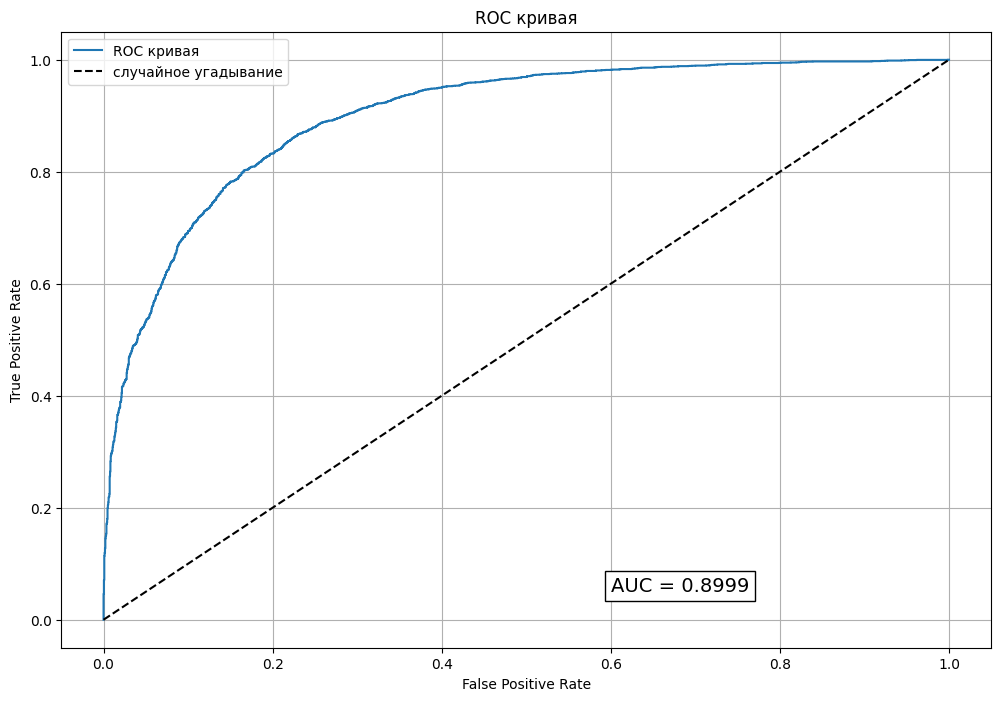

In [ ]:
ROC_AUC_picture(y_test, clf.predict_proba(X_test_df)[:, 1])

In [ ]:
def Precision_Recall_AUC_picture(y_true, y_pred):
  treshholds = np.linspace(0, 1, 100)
  recalls = []
  precisions = []
  for treshhold in treshholds:
    y_pred_bin = (y_pred >= treshhold).astype(int)
    recalls.append(recall_score(y_true, y_pred_bin))
    precisions.append(precision_score(y_true, y_pred_bin))

  plt.figure(figsize=(12, 8))

  plt.plot(recalls, precisions, label='Precision_Recall_AUC кривая')
  plt.text(0.6, 0.05, f'Precision_Recall AUC = { average_precision_score(y_true, y_pred):.4f}', fontsize=14, bbox=dict(facecolor='white', edgecolor='black'))

  img_path = 'Precision Recall AUC.png'
  plt.savefig(img_path, bbox_inches='tight')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision_Recall_AUC кривая')
  plt.legend()
  plt.grid()
  plt.show()



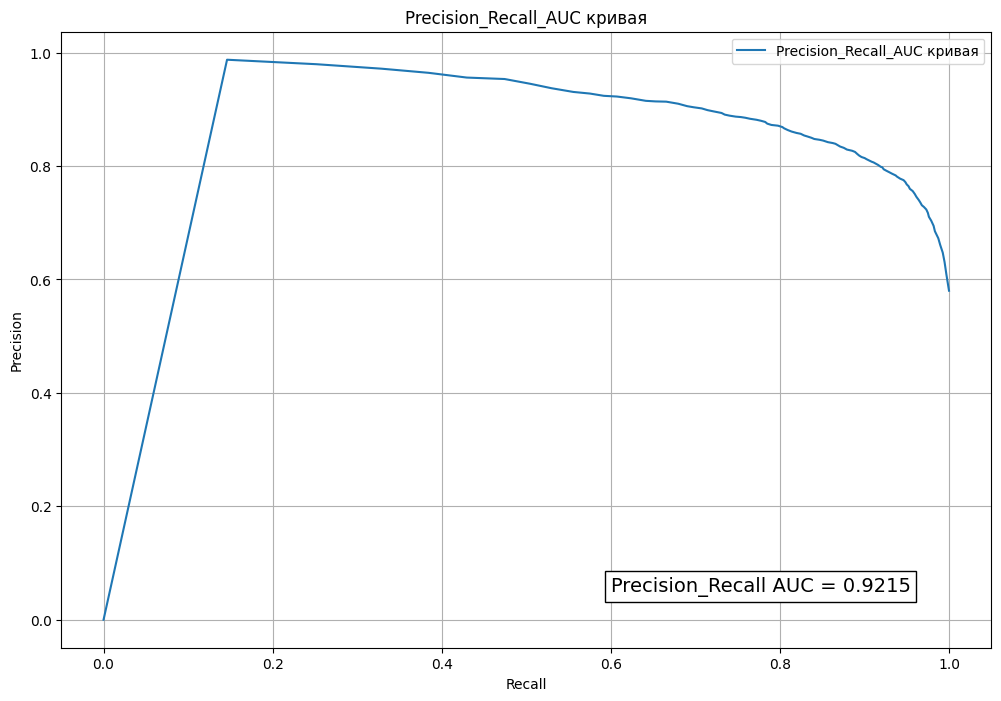

In [ ]:
Precision_Recall_AUC_picture(y_test, clf.predict_proba(X_test_df)[:, 1])

Отчетность в эксель

In [ ]:
from openpyxl.drawing.image import Image
from openpyxl.utils import get_column_letter

writer = pd.ExcelWriter("excel_report_.xlsx")
result.to_excel(writer, index=False, sheet_name="Metrix")

workbook  = writer.book
worksheet = writer.sheets["Metrix"]

n_cols = len(result.columns)
for i in range(n_cols):
    col_letter = get_column_letter(i + 1)
    worksheet.column_dimensions[col_letter].width = 20

img = Image('ROC-AUC.png')
img.width = 7 * 64
img.height = 15 * 20

img_2 = Image('Precision Recall AUC.png')
img_2.width = 7 * 64
img_2.height = 15 * 20

worksheet.add_image(img, 'A9')
worksheet.add_image(img_2, 'G9')

writer.close()